# Machine Failure Prediction Model Training

Binary classification model to predict equipment failures using the AI4I 2020 Predictive Maintenance Dataset. The goal is to minimize unplanned downtime by predicting failures before they occur.

**Dataset:** 10,000 records with sensor measurements (temperature, rotational speed, torque, tool wear)

**Sections:**
1. Setup & Imports
2. Data Loading & Exploration
3. Data Preprocessing
4. Model Training & Comparison
5. Hyperparameter Tuning
6. Final Evaluation & Visualization
7. Model Export

## 1. Setup & Imports

In [18]:
import numpy as np
import pandas as pd
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42

## 2. Data Loading & Exploration

In [19]:
df = pd.read_csv('data/ai4i2020.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [21]:
print("Missing values:")
print(df.isna().sum())
print(f"\nDuplicate rows: {df.duplicated().sum()}")

Missing values:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Duplicate rows: 0


In [22]:
print("Target distribution:")
print(df['Machine failure'].value_counts())
print(f"\nFailure rate: {df['Machine failure'].mean()*100:.2f}%")

Target distribution:
Machine failure
0    9661
1     339
Name: count, dtype: int64

Failure rate: 3.39%


## 3. Data Preprocessing

In [23]:
FEATURES = [
    'Type', 'Air temperature [K]', 'Process temperature [K]',
    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'
]
TARGET = 'Machine failure'

X = df[FEATURES].copy()
y = df[TARGET].astype(int).copy()

X = pd.get_dummies(X, columns=['Type'], drop_first=True, dtype=int)

numerical_cols = [col for col in X.columns if not col.startswith('Type_')]

print(f"Features: {X.columns.tolist()}")
print(f"Numerical columns: {numerical_cols}")

Features: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_L', 'Type_M']
Numerical columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Class imbalance ratio: {scale_pos_weight:.2f}")

train_path = 'data/train.csv'
test_path = 'data/test.csv'

X_train_full = X_train.copy()
X_train_full['Machine failure'] = y_train.values
X_test_full = X_test.copy()
X_test_full['Machine failure'] = y_test.values

X_train_full.to_csv(train_path, index=False)
X_test_full.to_csv(test_path, index=False)

print(f"Saved: {train_path}, {test_path}")

Training set: 8000 samples
Test set: 2000 samples
Class imbalance ratio: 28.52
Saved: data/train.csv, data/test.csv


In [25]:
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), numerical_cols)],
    remainder='passthrough'
)

## 4. Model Training & Comparison

In [26]:
def evaluate_model(y_true, y_pred, y_proba=None):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0),
    }
    if y_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_proba)
    return metrics

In [36]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=RANDOM_STATE)
}

results = []
confusion_matrices = {}

for name, model in models.items():
    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    confusion_matrices[name] = cm
    
    metrics = evaluate_model(y_test, y_pred, y_proba)
    metrics.update({'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Model': name})
    results.append(metrics)

results_df = pd.DataFrame(results).set_index('Model').sort_values('F1', ascending=False)

# Styled display with color gradients
styled_df = results_df[['TN', 'FP', 'FN', 'TP', 'Recall', 'Precision', 'F1', 'ROC-AUC']].style\
    .background_gradient(subset=['FN'], cmap='RdYlGn_r')\
    .background_gradient(subset=['FP'], cmap='RdYlGn_r')\
    .background_gradient(subset=['TP'], cmap='RdYlGn')\
    .background_gradient(subset=['Recall', 'Precision', 'F1', 'ROC-AUC'], cmap='RdYlGn')\
    .format({'Recall': '{:.2%}', 'Precision': '{:.2%}', 'F1': '{:.2%}', 'ROC-AUC': '{:.4f}'})

styled_df

,TN,FP,FN,TP,Recall,Precision,F1,ROC-AUC
Model,,,,,,,,
Gradient Boosting,1926,6,22,46,67.65%,88.46%,76.67%,0.9699
XGBoost,1910,22,16,52,76.47%,70.27%,73.24%,0.9615
Decision Tree,1915,17,26,42,61.76%,71.19%,66.14%,0.8044
Random Forest,1930,2,36,32,47.06%,94.12%,62.75%,0.9631
KNN,1928,4,49,19,27.94%,82.61%,41.76%,0.8368
AdaBoost,1922,10,48,20,29.41%,66.67%,40.82%,0.9515
Logistic Regression,1593,339,12,56,82.35%,14.18%,24.19%,0.9069


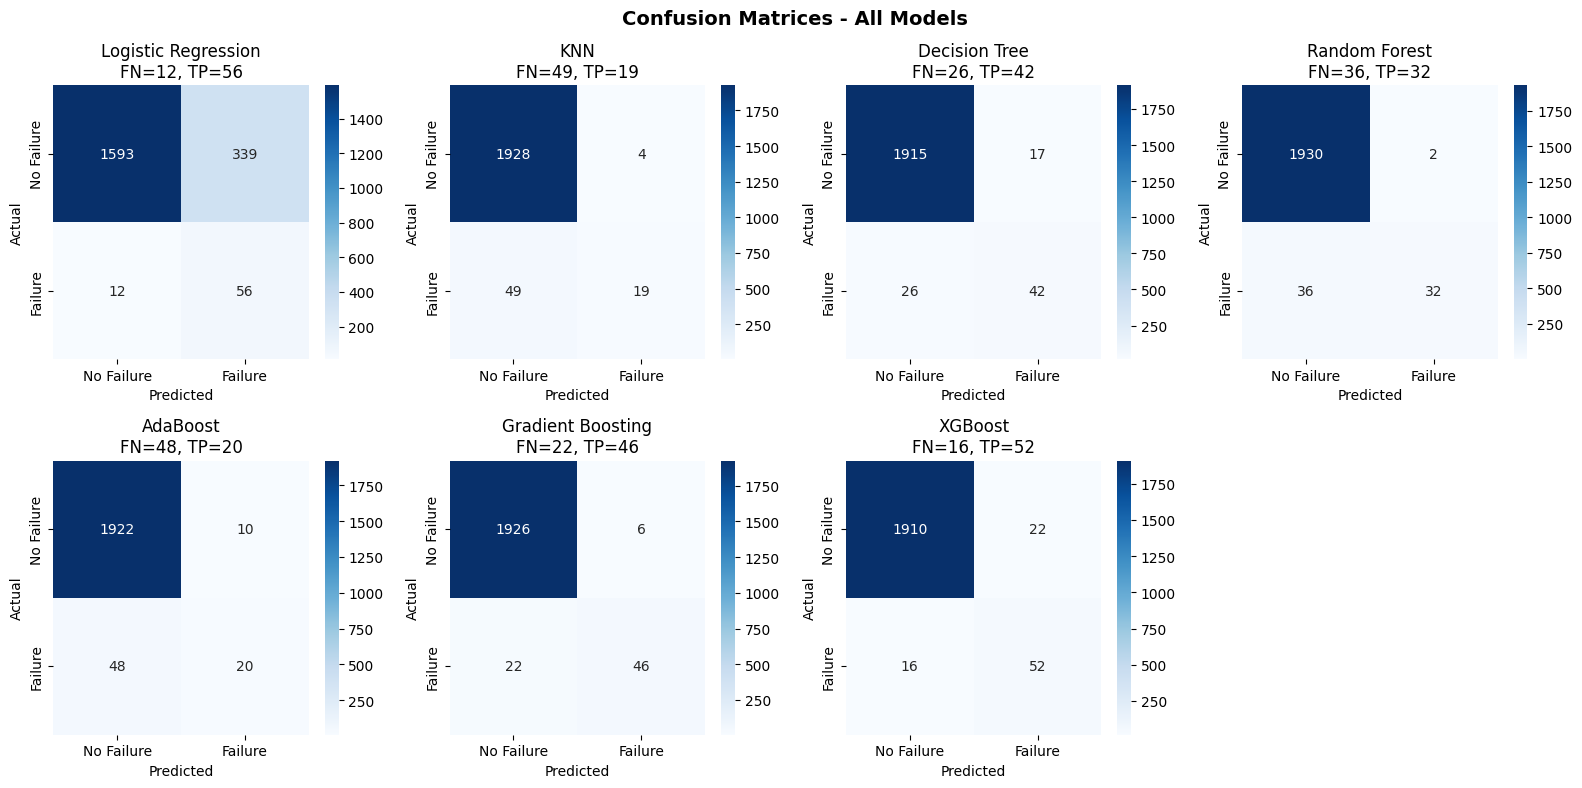

In [28]:
# Visualize confusion matrices for all models
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
    axes[idx].set_title(f'{name}\nFN={cm[1,0]}, TP={cm[1,1]}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

axes[-1].axis('off')
plt.suptitle('Confusion Matrices - All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.1 Model Selection: Why XGBoost?

Comparing models based on:
- **False Negatives (FN)**: Missed failures - CRITICAL to minimize
- **False Positives (FP)**: False alarms - Should be reasonable for credibility
- **Recall**: Percentage of actual failures caught
- **Precision**: When we predict failure, how often are we correct?

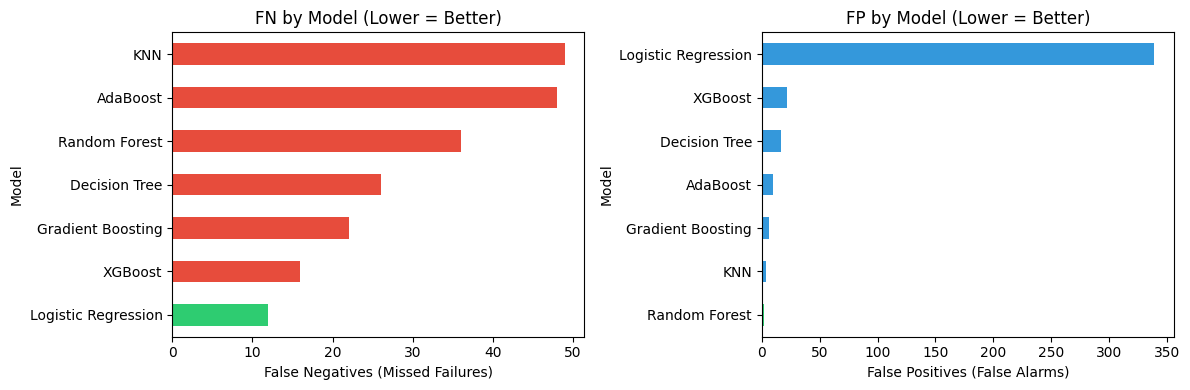


RECOMMENDATION FOR PREDICTIVE MAINTENANCE

✓ Best model by lowest FN (missed failures): Logistic Regression
  - Missed failures: 12 out of 68
  - Recall: 82.35%

✓ Best model by highest Recall: Logistic Regression
  - Recall: 82.35%
  - False Positives (false alarms): 339


In [35]:
# Compare FN and FP across models - Simplified charts
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# FN comparison
fn_sorted = results_df.sort_values('FN')['FN']
colors = ['#2ecc71' if x == fn_sorted.min() else '#e74c3c' for x in fn_sorted.values]
fn_sorted.plot(kind='barh', ax=axes[0], color=colors)
axes[0].set_xlabel('False Negatives (Missed Failures)')
axes[0].set_title('FN by Model (Lower = Better)')

# FP comparison  
fp_sorted = results_df.sort_values('FP')['FP']
colors = ['#2ecc71' if x == fp_sorted.min() else '#3498db' for x in fp_sorted.values]
fp_sorted.plot(kind='barh', ax=axes[1], color=colors)
axes[1].set_xlabel('False Positives (False Alarms)')
axes[1].set_title('FP by Model (Lower = Better)')

plt.tight_layout()
plt.show()

# Print recommendation
best_fn_model = results_df['FN'].idxmin()
best_recall_model = results_df['Recall'].idxmax()

print("\n" + "="*60)
print("RECOMMENDATION FOR PREDICTIVE MAINTENANCE")
print("="*60)
print(f"\n✓ Best model by lowest FN (missed failures): {best_fn_model}")
print(f"  - Missed failures: {results_df.loc[best_fn_model, 'FN']:.0f} out of {(y_test == 1).sum()}")
print(f"  - Recall: {results_df.loc[best_fn_model, 'Recall']:.2%}")
print(f"\n✓ Best model by highest Recall: {best_recall_model}")
print(f"  - Recall: {results_df.loc[best_recall_model, 'Recall']:.2%}")
print(f"  - False Positives (false alarms): {results_df.loc[best_recall_model, 'FP']:.0f}")


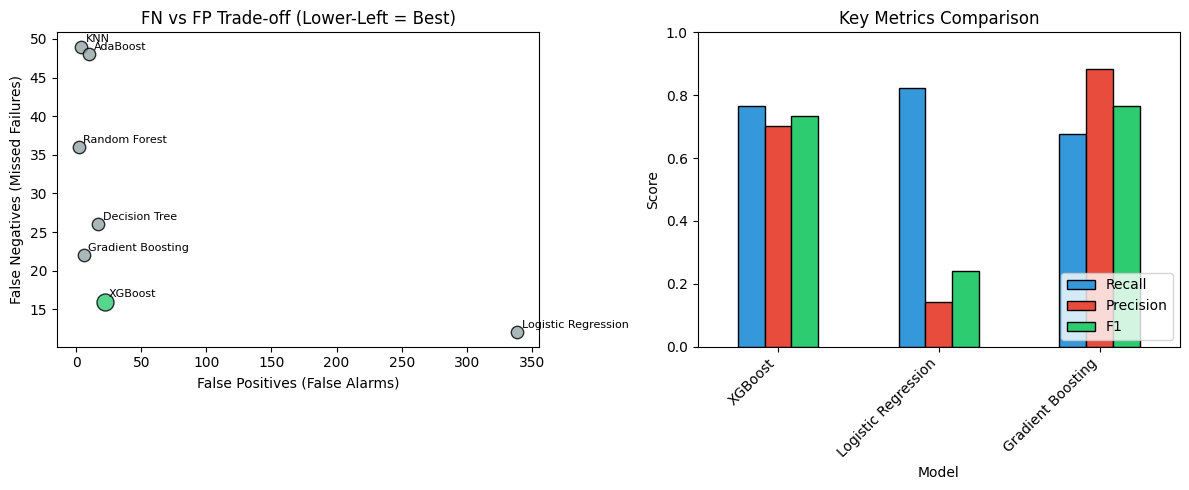

Selected Model: XGBoost (Best FN/FP balance for predictive maintenance)


In [30]:
# Model Selection Analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: FN vs FP Trade-off
for model in results_df.index:
    fn, fp = results_df.loc[model, 'FN'], results_df.loc[model, 'FP']
    color = '#2ecc71' if model == 'XGBoost' else '#95a5a6'
    size = 150 if model == 'XGBoost' else 80
    axes[0].scatter(fp, fn, s=size, c=color, edgecolors='black', alpha=0.8)
    axes[0].annotate(model, (fp, fn), fontsize=8, xytext=(3, 3), textcoords='offset points')

axes[0].set_xlabel('False Positives (False Alarms)')
axes[0].set_ylabel('False Negatives (Missed Failures)')
axes[0].set_title('FN vs FP Trade-off (Lower-Left = Best)')

# Plot 2: Key metrics comparison
models_compare = ['XGBoost', 'Logistic Regression', 'Gradient Boosting']
metrics_compare = ['Recall', 'Precision', 'F1']
compare_df = results_df.loc[models_compare, metrics_compare]
compare_df.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
axes[1].set_ylabel('Score')
axes[1].set_title('Key Metrics Comparison')
axes[1].set_xticklabels(models_compare, rotation=45, ha='right')
axes[1].legend(loc='lower right')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"Selected Model: XGBoost (Best FN/FP balance for predictive maintenance)")

## 5. Hyperparameter Tuning (XGBoost)

In [31]:
from sklearn.metrics import make_scorer

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', 
                                  random_state=RANDOM_STATE, use_label_encoder=False))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.15],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__scale_pos_weight': [scale_pos_weight, scale_pos_weight * 1.2, scale_pos_weight * 1.5],
}

search = RandomizedSearchCV(pipeline, param_grid, n_iter=30, scoring='f1', cv=cv, 
                            n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
search.fit(X_train, y_train)

print(f"Best CV F1 Score: {search.best_score_:.4f}")
print(f"Best Parameters: {search.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV F1 Score: 0.7589
Best Parameters: {'classifier__subsample': 0.8, 'classifier__scale_pos_weight': np.float64(28.52029520295203), 'classifier__n_estimators': 400, 'classifier__min_child_weight': 1, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0, 'classifier__colsample_bytree': 1.0}
Best CV F1 Score: 0.7589
Best Parameters: {'classifier__subsample': 0.8, 'classifier__scale_pos_weight': np.float64(28.52029520295203), 'classifier__n_estimators': 400, 'classifier__min_child_weight': 1, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0, 'classifier__colsample_bytree': 1.0}


## 6. Final Evaluation & Visualization

In [32]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=['No Failure', 'Failure']))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

final_metrics = evaluate_model(y_test, y_pred, y_proba)
print(f"\nTest Metrics: {final_metrics}")

              precision    recall  f1-score   support

  No Failure       0.99      0.99      0.99      1932
     Failure       0.76      0.79      0.78        68

    accuracy                           0.98      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix: TN=1915, FP=17, FN=14, TP=54

Test Metrics: {'Accuracy': 0.9845, 'Precision': 0.7605633802816901, 'Recall': 0.7941176470588235, 'F1': 0.7769784172661871, 'ROC-AUC': 0.9671933990987699}


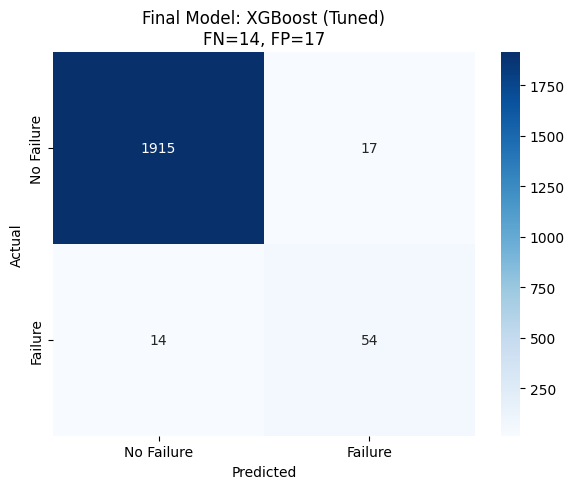

In [33]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
ax.set_title(f'Final Model: XGBoost (Tuned)\nFN={fn}, FP={fp}')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

## 7. Model Export

In [ ]:
MODEL_DIR = '../models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Save only the artifacts used by main.py
with open(f'{MODEL_DIR}/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

with open(f'{MODEL_DIR}/model.pkl', 'wb') as f:
    pickle.dump(best_model.named_steps['classifier'], f)

print(f"Models saved to {MODEL_DIR}/")
print(f"  - preprocessor.pkl (ColumnTransformer scaler)")
print(f"  - model.pkl (XGBoost classifier)")

Models saved to ../models/
